notes to self:

* change Measurement to 0/1
* add all freqs and orders by nesting `Freqs/Order`

# Data import

In [142]:
library(tidyverse)
library(broom)
library(lme4)
library(Hmisc)
library(lattice)
library(ggpubr)
library(effectsize)
library(gridExtra)

options(repr.plot.width=7, repr.plot.height=4)

In [165]:
residuals_plots <- function(model){
    p1 <- ggplot(data = data.frame(residuals = summary(model)$res)) +
        geom_histogram(aes(x = residuals), bins = 25, 
                       fill = "lightblue", color = "black") +
        labs(title = "Histogram of Residuals")

    p2 <- ggplot(data = data.frame(residuals = summary(model)$res), 
           aes(sample = residuals)) +
        stat_qq() + 
        stat_qq_line() +
        labs(title = "QQ Plot of Residuals")
    
    grid.arrange(p1, p2, nrow = 1)
    
    p1 <- plot(model, resid(.) ~ fitted(.), abline=0, main = "All Data")
    p2 <- plot(model, resid(.) ~ fitted(.)|Animal, abline=0, main = "By Animal")
    
    grid.arrange(p1, p2, nrow = 1, widths = c(1.5,2))
}

In [3]:
AVRECPeakAM <- read_csv(file = "../Data/AVRECPeakAMST.csv")

Parsed with column specification:
cols(
  Group = col_character(),
  Animal = col_character(),
  Layer = col_character(),
  Measurement = col_character(),
  ClickFreq = col_double(),
  OrderofClick = col_double(),
  TrialNumber = col_double(),
  PeakAmp = col_double(),
  PeakLat = col_double(),
  RMS = col_double()
)


# Modeling

Notes:

* `RMS` variable was log-transformed since the distribution was right-skewed (resulting in a fan shape residuals plots).
* Values in `coef()` function is the actual intercept for an animal. `ranef()` shows the difference from a "main" intercept.


Warning message:
“Removed 107928 rows containing non-finite values (stat_bin).”Warning message:
“Removed 107928 rows containing non-finite values (stat_bin).”

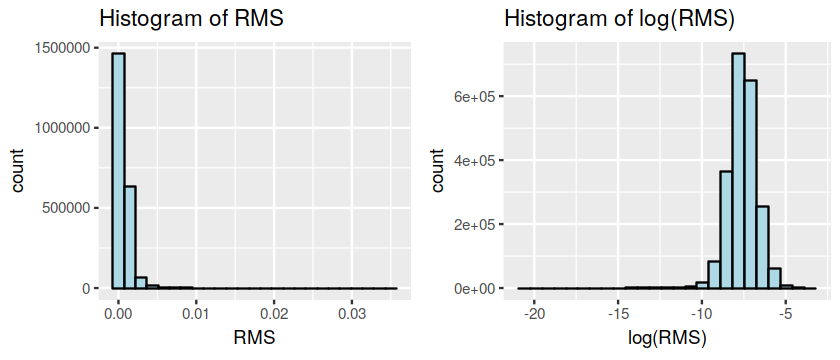

In [144]:
p1 <- ggplot(data = AVRECPeakAM) +
    geom_histogram(aes(x = RMS), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of RMS")

p2 <- ggplot(data = AVRECPeakAM) +
    geom_histogram(aes(x = log(RMS)), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Histogram of log(RMS)")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

## logRMS ~ Group\*Measurement\*Layer + ClickFreq + (...|Animal)

* Random effect: Animal
* Fixed effect: Group\*Measurement\*Layer, ClickFreq
* Measurement = ["preAM_1", "AM_1"], [0, 1]
* OrderofClick = 1

In [140]:
temp_df <- AVRECPeakAM %>% 
    filter(
        OrderofClick == 1,
        Layer != "All",
        Measurement %in% c("preAM_1", "AM_1")) %>% 
    mutate(logRMS = log(RMS)) %>% 
    ungroup() %>% 
    drop_na()

temp_df$Measurement <- factor(
    x = temp_df$Measurement, 
    levels = c("preAM_1", "AM_1"))

temp_df$Layer <- factor(x = temp_df$Layer)
# temp_df$ClickFreq <- factor(x = temp_df$ClickFreq)

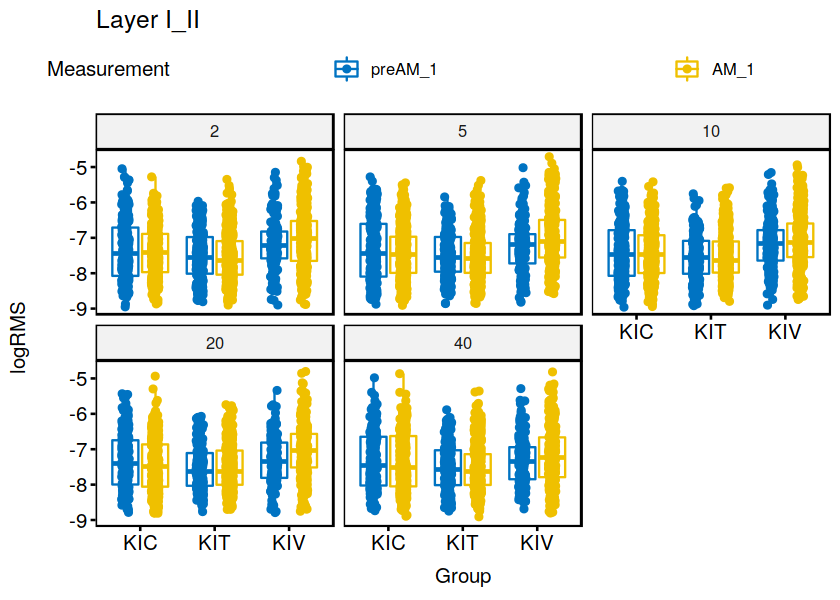

In [148]:
options(repr.plot.width=7, repr.plot.height=5)

temp_df  %>% 
    filter(Layer == "I_II") %>%  # "I_II", "IV", "V", "VI"
ggboxplot(
    x = "Group", y = "logRMS", color = "Measurement", 
    palette = "jco", add = "jitter", facet.by = "ClickFreq", main = "Layer I_II"
)

In [17]:
head(temp_df)

Group,Animal,Layer,Measurement,ClickFreq,OrderofClick,TrialNumber,PeakAmp,PeakLat,RMS,logRMS
KIC,KIC02,I_II,preAM_1,2,1,1,0.001483936,21,0.0007726788,-7.165647
KIC,KIC02,I_II,preAM_1,2,1,2,0.001250764,28,0.0005488973,-7.507599
KIC,KIC02,I_II,preAM_1,2,1,3,0.004439501,34,0.0018238557,-6.306803
KIC,KIC02,I_II,preAM_1,2,1,4,0.002350430,46,0.0016744506,-6.392270
KIC,KIC02,I_II,preAM_1,2,1,5,0.001809858,76,0.0009579004,-6.950767
KIC,KIC02,I_II,preAM_1,2,1,6,0.002856180,81,0.0017449100,-6.351052


### (1|Animal); random intercept, fixed slope

We assume that every animal has different "starting point", but the same rate of change (slope).

In [38]:
model0 <- lmer(
    formula = logRMS ~ Group*Measurement*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (1|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model0)

# ClickFreq/OrderofClick
# control = lmerControl(optimizer ='optimx', optCtrl=list(method='nlminb'))


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * Measurement * Layer + ClickFreq + (1 | Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 65562.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4598 -0.6835 -0.0050  0.6678  4.6780 

Random effects:
 Groups             Name        Variance Std.Dev.
 TrialNumber:Animal (Intercept) 0.006275 0.07922 
 Animal             (Intercept) 0.098472 0.31380 
 Residual                       0.388117 0.62299 
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.2813961  0.1010740 -72.040
GroupKIT                         -0.1178256  0.1429627  -0.824
GroupKIV                          0.0663623  0.1572074   0.422
MeasurementAM_1                  -0.0622335  0.0236441  -2.632
LayerIV                           0.3213435  0.0259561  12.380
LayerV                           

$`TrialNumber:Animal`

$Animal


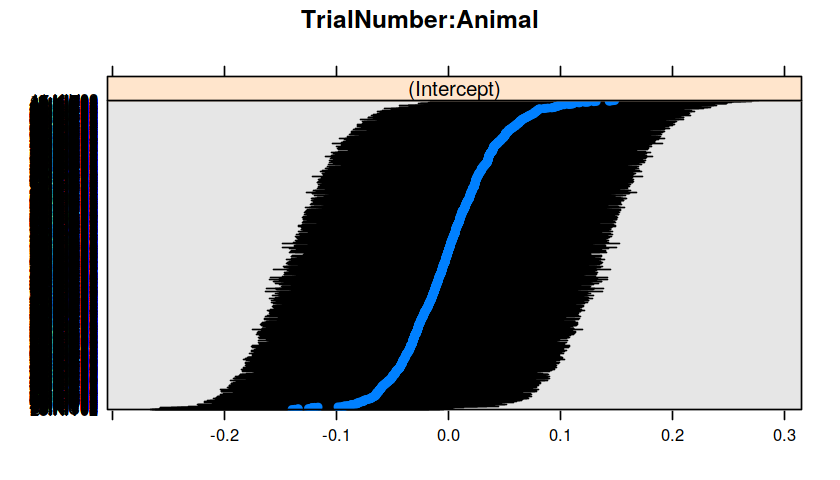

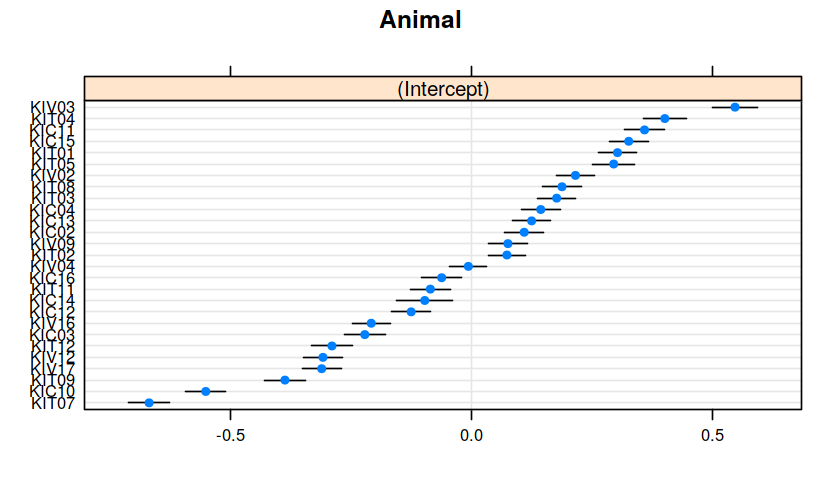

In [157]:
options(repr.plot.width=7, repr.plot.height=4)
dotplot(ranef(model0, condVar = TRUE))

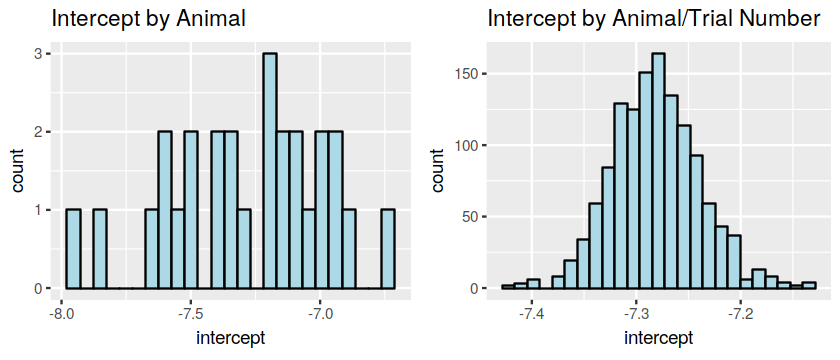

In [161]:
p1 <- ggplot(data = data.frame(intercept = coef(model0)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model0)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=3)
grid.arrange(p1, p2, nrow = 1)

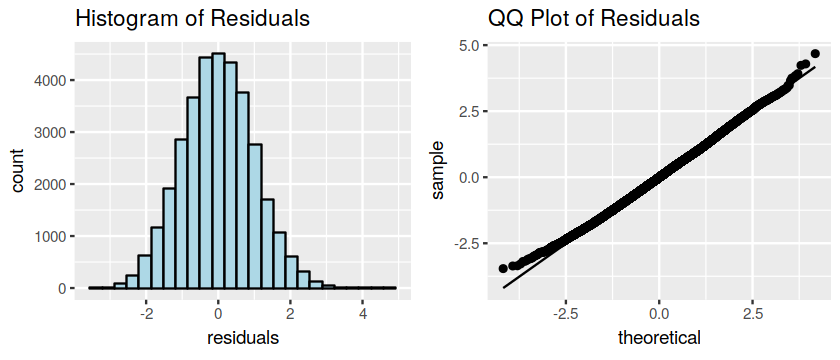

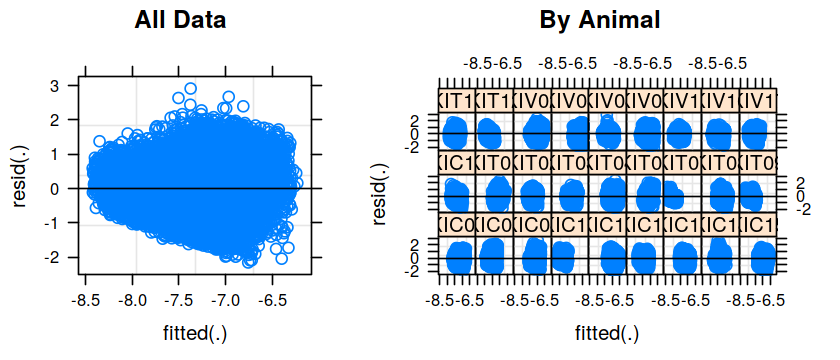

In [167]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model0)

### (Measurement|Animal); random intercept & slopes

In [168]:
model1 <- lmer(
    formula = logRMS ~ Group*Measurement*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (Measurement|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model1)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: logRMS ~ Group * Measurement * Layer + ClickFreq + (Measurement |  
    Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 64993.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5981 -0.6786 -0.0053  0.6713  4.6998 

Random effects:
 Groups             Name            Variance Std.Dev. Corr 
 TrialNumber:Animal (Intercept)     0.004413 0.06643       
                    MeasurementAM_1 0.013231 0.11502  -0.45
 Animal             (Intercept)     0.102224 0.31972       
                    MeasurementAM_1 0.034213 0.18497  -0.22
 Residual                           0.378925 0.61557       
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.2807632  0.1028521 -70.789
GroupKIT                         -0.1163225  0.1454997  -0.799
GroupKIV                          0.0687311  0.

$`TrialNumber:Animal`

$Animal


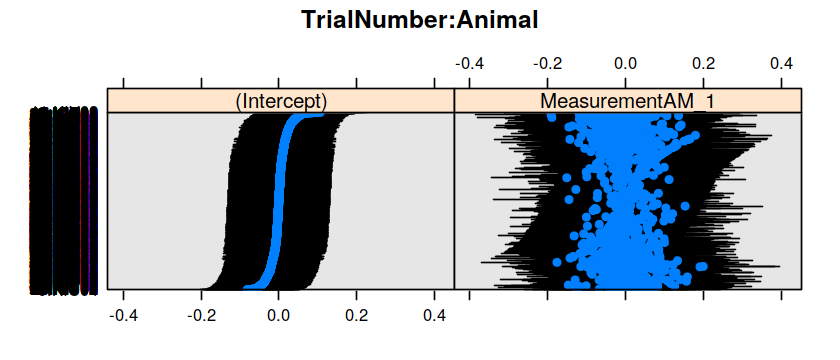

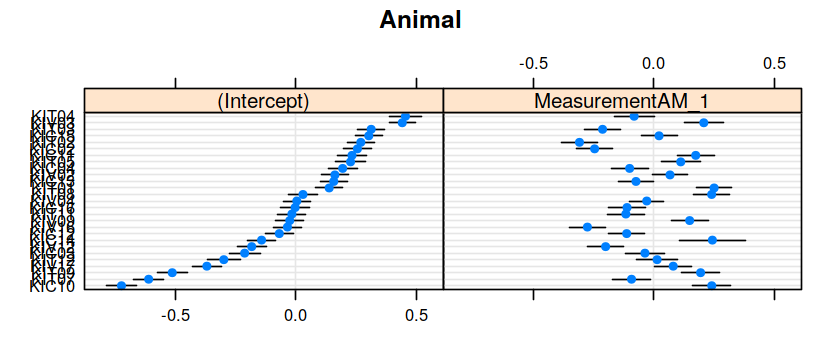

In [169]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model1, condVar = TRUE))

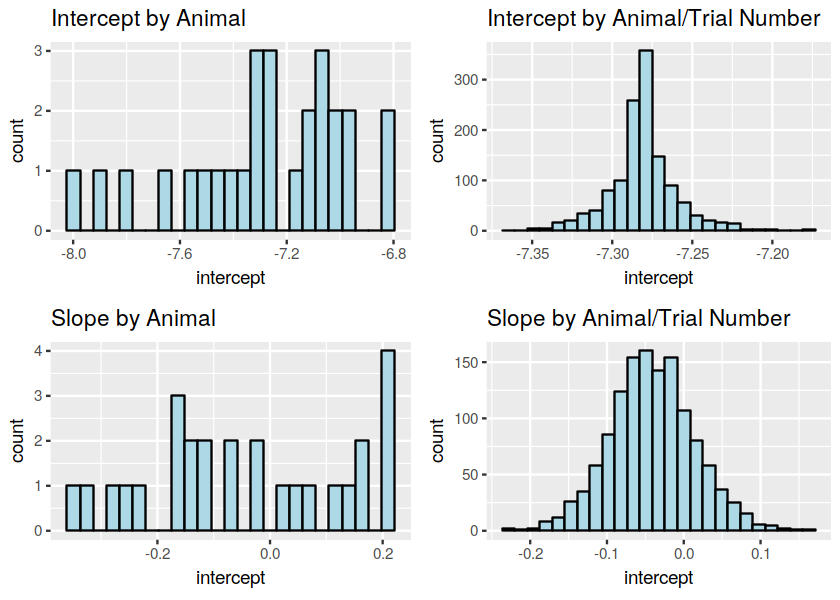

In [174]:
p1 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal")

p2 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$`(Intercept)`)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Intercept by Animal/Trial Number")

p3 <- ggplot(data = data.frame(intercept = coef(model1)$Animal$MeasurementAM_1)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal")

p4 <- ggplot(data = data.frame(intercept = coef(model1)$`TrialNumber:Animal`$MeasurementAM_1)) +
    geom_histogram(aes(x = intercept), bins = 25, 
                   fill = "lightblue", color = "black") +
    labs(title = "Slope by Animal/Trial Number")

options(repr.plot.width=7, repr.plot.height=5)
grid.arrange(p1, p2, p3, p4, nrow = 2)

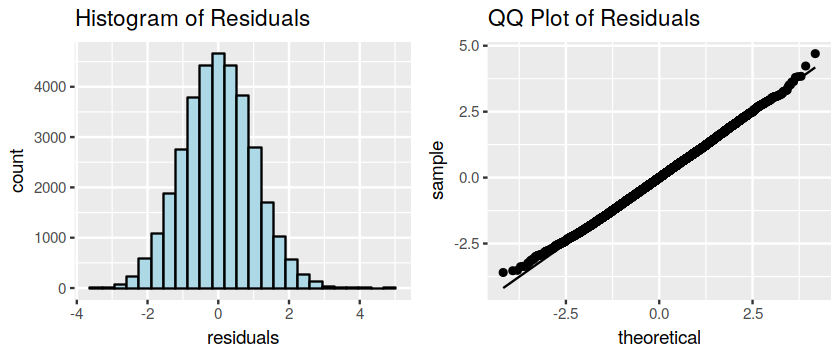

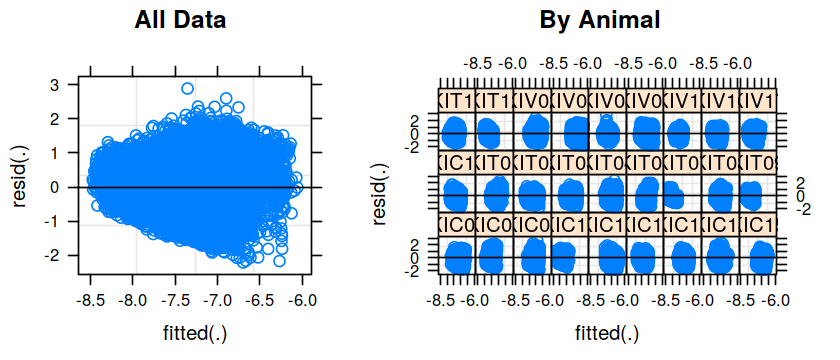

In [176]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model1)

### (-1 + Measurement|Animal); fixed intercept, random slopes

In [177]:
model2 <- lmer(
    formula = logRMS ~ Group*Measurement*Layer + ClickFreq + 
#         (1|ClickFreq) + 
        (-1 + Measurement|Animal/TrialNumber), 
    data = temp_df,
    REML = TRUE)
summary(model2)


Correlation matrix not shown by default, as p = 25 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML ['lmerMod']
Formula: 
logRMS ~ Group * Measurement * Layer + ClickFreq + (-1 + Measurement |  
    Animal/TrialNumber)
   Data: temp_df

REML criterion at convergence: 64993.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5981 -0.6786 -0.0053  0.6713  4.6998 

Random effects:
 Groups             Name               Variance Std.Dev. Corr
 TrialNumber:Animal MeasurementpreAM_1 0.004413 0.06643      
                    MeasurementAM_1    0.010843 0.10413  0.15
 Animal             MeasurementpreAM_1 0.102245 0.31976      
                    MeasurementAM_1    0.110628 0.33261  0.84
 Residual                              0.378924 0.61557      
Number of obs: 34280, groups:  TrialNumber:Animal, 1302; Animal, 27

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                      -7.2807632  0.1028623 -70.782
GroupKIT                         -0.1163223  0.1455142  -0.799
GroupKIV                     

$`TrialNumber:Animal`

$Animal


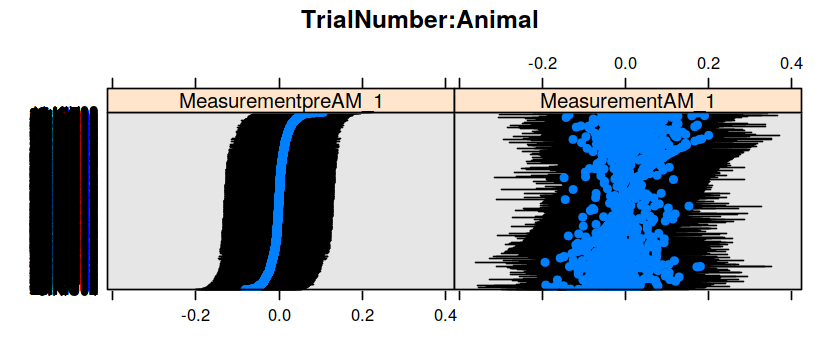

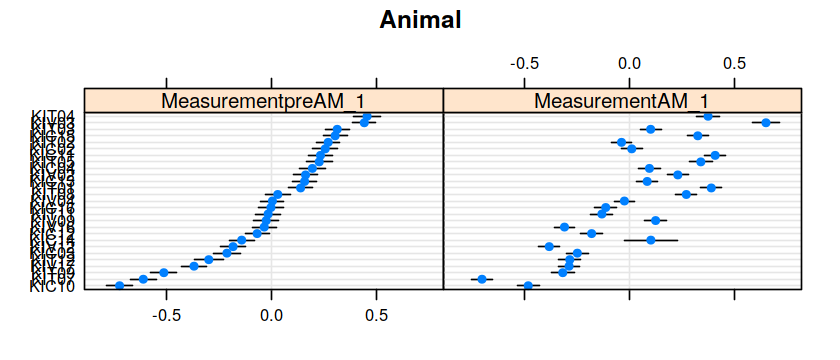

In [178]:
options(repr.plot.width=7, repr.plot.height=3)
dotplot(ranef(model2, condVar = TRUE))

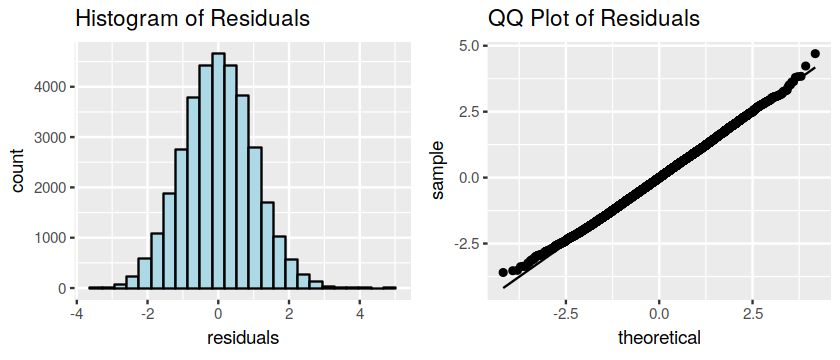

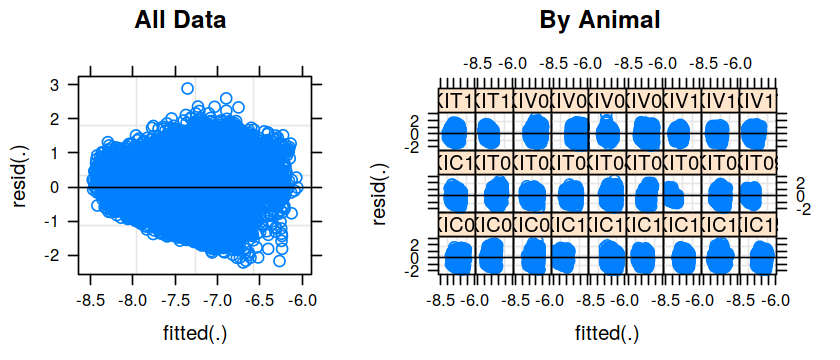

In [179]:
options(repr.plot.width=7, repr.plot.height=3)
residuals_plots(model = model2)

## Comparison

In [182]:
anova(model0, model1, model2)

refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
model0,28,65469.21,65705.59,-32706.60,65413.21,NA,NA,NA
model1,32,64917.53,65187.68,-32426.77,64853.53,559.6763,4,8.247006e-120
model2,32,64917.53,65187.68,-32426.77,64853.53,0.0000,0,NA
